# From the collective dipole moment to the dielectric relaxation spectrum

In [1]:
import numpy as np
from matplotlib import pyplot as plt

first we obtain the collective dipole moment (md), which we calculate just as the sum of molecular dipole moments. We have one for the whole system, and for each species seperately.

In [2]:
residues = ["IM1H", "OAC", "IM1", "HOAC"]
md = {}
md["all"] = np.loadtxt("data/md_all.txt")
for residue in residues:
    md[residue] = np.loadtxt(f"data/md_{residue}.txt")
dt = 1 #ps
n = 5000 #frames
time_axis = np.arange(0, n*dt, dt)

## Auto correlation function
We will use a small subarray, to show how the autocorrelation fuction is calculated:

In [3]:
short = md["all"].T[:,0:3]
print(short)

[[ -1.00320728 -19.900516    -3.88271606]
 [-21.82201517 -18.23343125 -14.70222407]
 [  9.82434817  -0.79922288   9.19884293]]


This array contains as rows the x,y,z compoment of the dipole and as columns the timesteps. So in this case we just use 3 steps.

Next we want to compute the autocorrelation function, which will result in one value for each timestep.
To do so, we basically multiply short*short, and move one array one step further.

At t=0: (x1\*x1 + x2\*x2 + x3\*x3)/3 , the same for y and z and then we take the sum of x+y+z, for our value for the autocorrelation function at t=0.

At t=1: (x1\*x2 + x2\*x3)/2 , the same for y and z and then we take the sum of x+y+z, for our value for the autocorrelation function at t=1.

At t=2: (x1\*x3) the same for y and z and then we take the sum of x+y+z, for our value for the autocorrelation function at t=2.

Additionally, we always subtract the average value from each value, so x1 = x1-x_mean, x2=x2-x_mean, y1=y1-y_mean and so on

In [4]:
x1, x2, x3 = short[0,:]
xm = short[0,:].mean()
y1, y2, y3 = short[1,:]
ym = short[1,:].mean()
z1, z2, z3 = short[2,:]
zm = short[2,:].mean()

In [5]:
#first value
x = ((x1-xm)*(x1-xm) + (x2-xm)*(x2-xm) + (x3-xm)*(x3-xm))/3
y = ((y1-ym)*(y1-ym) + (y2-ym)*(y2-ym) + (y3-ym)*(y3-ym))/3
z = ((z1-zm)*(z1-zm) + (z2-zm)*(z2-zm) + (z3-zm)*(z3-zm))/3
first_value = x+y+z
print(first_value)

101.24682063567212


In [6]:
# second value
x = ((x1-xm)*(x2-xm) + (x2-xm)*(x3-xm))/2
y = ((y1-ym)*(y2-ym)+(y2-ym)*(y3-ym))/2
z = ((z1-zm)*(z2-zm)+(z2-zm)*(z3-zm))/2
second_value = x+y+z
print(second_value)

-91.35111181454174


In [7]:
# third value
x = (x1-xm)*(x3-xm)
y = (y1-ym)*(y3-ym)
z = (z1-zm)*(z3-zm)
third_value = x+y+z
print(third_value)

30.831992675575297


Now do it for a longer array:

In [8]:
def correlate(data: np.ndarray) -> np.ndarray:
    # data should be of shape (3, timesteps) 3 for x,y,z
    avg = data.mean(axis=1, keepdims=True)
    new_data = data - avg

    corr = []
    #first value (t0):
    corr.append((new_data*new_data).mean(axis=1).sum())
    # from t1 to t_n
    for i in range(1,data.shape[1]):
        val = (new_data[:,:-i]*new_data[:,i:]).mean(axis=1).sum()
        corr.append(val)
        
    return np.asarray(corr)

(5000,)


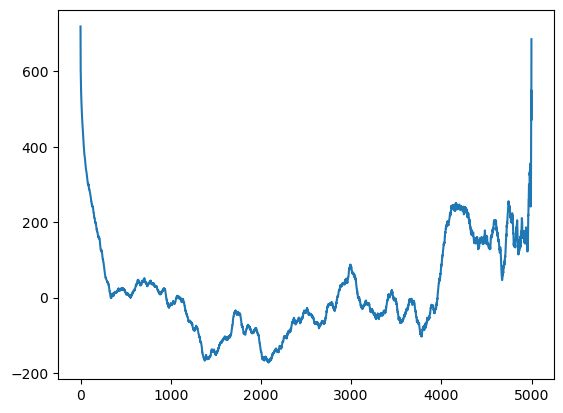

In [9]:
corr_all = correlate(md["all"].T)
np.savetxt("corr_all.dat", np.c_[time_axis,corr_all])
print(corr_all.shape)
plt.plot(time_axis, corr_all)

Usually we use the function from newanalysis. (available at https://github.com/cbc-univie/mdy-newanalysis-package)

In [11]:
from newanalysis.correl import correlateParallel
corr_newanalysis = np.zeros(n)
correlateParallel(md["all"].T, md["all"].T, corr_newanalysis, ltc=1) # ltc=1 means subtracting the average value from each value

and it gives the exact same result

Are the arrays equal?: True


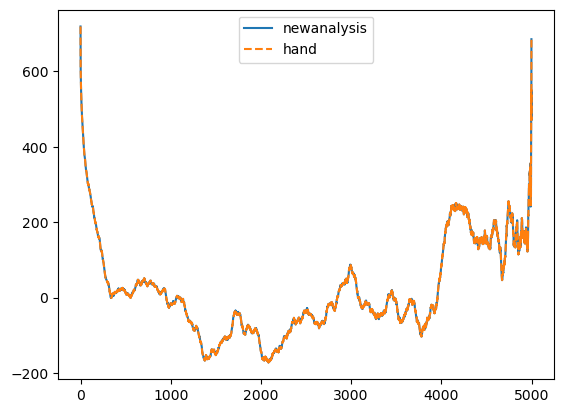

In [12]:
print("Are the arrays equal?:", np.allclose(corr_all, corr_newanalysis))
plt.plot(time_axis, corr_newanalysis, ls="-", label="newanalysis")
plt.plot(time_axis, corr_all, ls="--", label="hand")
plt.legend()
plt.show()

The next step can either be to fit the correlation function, or just use the data directly to calcualte the spectrum

In [24]:
from cbchelpers.gendicon import prepare_mdmd_fromJson, fit_mdmd

In [31]:
input = prepare_mdmd_fromJson("MDMD_fit.json")
fit_results = fit_mdmd(input)

< Json Input:
	data         =  corr_all.dat
	residuals    =  corr_all_fit_1000.dat
	maximal time =  1000
	boxlength   =  None

	exp:
		a =    1.21455        	tau =    1.44160        
		a =    3.21455        	tau =    6.44160        
		a =   28.78434        	tau = 1021.27942        

	Fit model =  ampgo


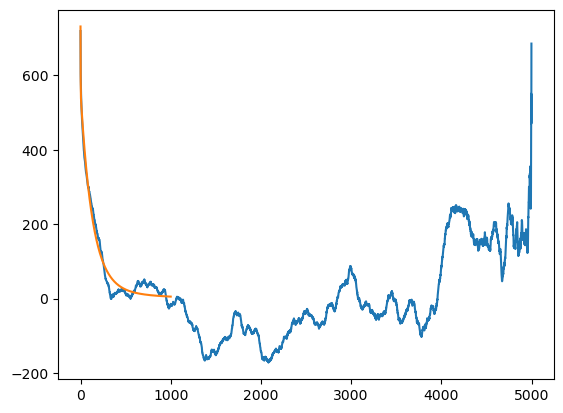

In [32]:
plt.plot(corr_all)
plt.plot(fit_results.fit)

In [33]:
import subprocess
subprocess.call(["gendicon", "input.json"])

			GENeralized DIelectric CONstant
		Version: Lithium


------------------------------------------------------------------------------------------------------------------------
1. Correlation functions 
------------------------------------------------------------------------------------------------------------------------
> 1.1 Reading Json file input.json ...

> 1.2 Setting up correlation functions ...

>	--------------------------------------------------------------------------------
>	Correlation Function: <MD(0)*MD(t)>
>	--------------------------------------------------------------------------------
		Name:           all
		Input:      corr_all.dat

		Fitfunctions:
			EXP:          1.215 * exp( -t/    1.442) +    0.000
			EXP:          3.215 * exp( -t/    6.442) +    0.000
			EXP:         28.784 * exp( -t/ 1021.279) +    0.000


------------------------------------------------------------------------------------------------------------------------
2. Dielectric spectra 
-----------

0

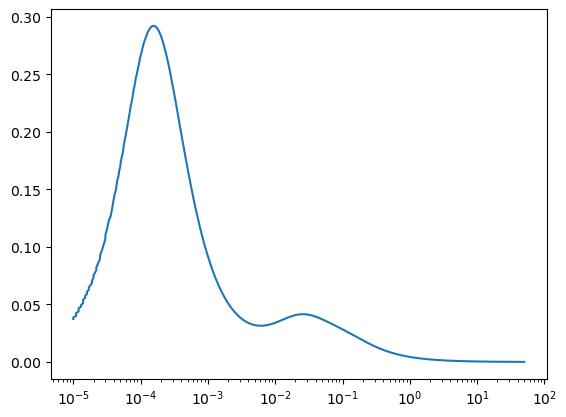

In [36]:
freq, real, imag = np.loadtxt("epsilon_all.dat", unpack=True)
plt.plot(freq, imag)
plt.xscale("log")